# KNN


In [1]:
from sklearn.model_selection import train_test_split
from scipy.spatial import distance

from assignment_2.digits_classifiers.model import Dataset, ClassifierTuning
from assignment_2.digits_classifiers.classifiers import KNN
from assignment_2.digits_classifiers.io import read_datasets

## Import dataset

In [2]:
data = read_datasets()

2022-12-22 09:49:07.579 | INFO     | assignment_2.digits_classifiers.io:read_datasets:46 - Reading datasets


In [3]:
X, y = data

## Removing constant columns

In [4]:
always_zero = [c for c in list(X.columns) if sum(X.loc[:, c]) == 0]

In [5]:
X.drop(columns=always_zero, axis=1, inplace=True)

## Discard part of data

In [6]:
X, _, y, _ = train_test_split(X, y, test_size=0.98)

## Train Test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [8]:
X_train

,pixel13,pixel14,pixel15,pixel16,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
data = Dataset(x=X, y=y)
train = Dataset(x=X_train, y=y_train)
test = Dataset(x=X_test, y=y_test)

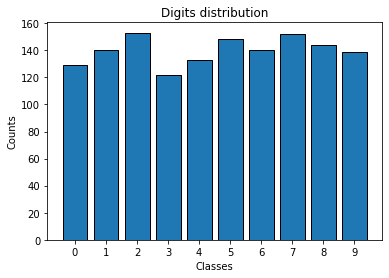

In [10]:
data.digit_distribution()

## Trial

In [12]:
X_train

,pixel13,pixel14,pixel15,pixel16,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
import numpy as np

X_train_arr = np.array(X_train)
X_train_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
X_train_arr[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

## Training KNN

In [24]:
knns = [
    KNN(train=train, test=test, params={"k": k, "f_distance": dist})
    for k in [10, 20]
    for dist in [distance.euclidean]
]

In [25]:
tuning_knns = ClassifierTuning(classifiers=knns, base_estimator=KNN.default_estimator(), data=train, k=5)

In [26]:
tuning_knns.evaluate()

In [27]:
best_knn = KNN(train=train, test=test, params=tuning_knns.best_params)
best_knn

[KNN: Train 1120, Test 280, not fitted, not predicted] [k: 10; distance: <function euclidean at 0x000002AFDB542AF0>]

In [28]:
best_knn.train()
best_knn.predict()
best_knn.accuracy

2022-12-17 00:35:40.551 | INFO     | assignment_2.digits_classifiers.classifiers:predict:253 -  > 0.000%
2022-12-17 00:35:42.151 | INFO     | assignment_2.digits_classifiers.classifiers:predict:253 -  > 3.571%
2022-12-17 00:35:44.274 | INFO     | assignment_2.digits_classifiers.classifiers:predict:253 -  > 7.143%
2022-12-17 00:35:46.579 | INFO     | assignment_2.digits_classifiers.classifiers:predict:253 -  > 10.714%
2022-12-17 00:35:48.919 | INFO     | assignment_2.digits_classifiers.classifiers:predict:253 -  > 14.286%
2022-12-17 00:35:50.806 | INFO     | assignment_2.digits_classifiers.classifiers:predict:253 -  > 17.857%
2022-12-17 00:35:52.870 | INFO     | assignment_2.digits_classifiers.classifiers:predict:253 -  > 21.429%
2022-12-17 00:35:55.023 | INFO     | assignment_2.digits_classifiers.classifiers:predict:253 -  > 25.000%
2022-12-17 00:35:57.041 | INFO     | assignment_2.digits_classifiers.classifiers:predict:253 -  > 28.571%
2022-12-17 00:35:59.115 | INFO     | assignment_2

0.8821428571428571

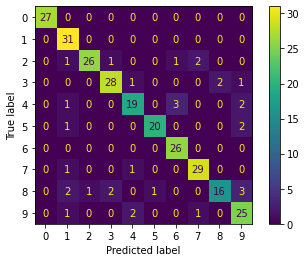

In [29]:
best_knn.confusion_matrix()